In [3]:
import sys, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import torch._dynamo
torch._dynamo.config.suppress_errors = True

2.5.1+cu121


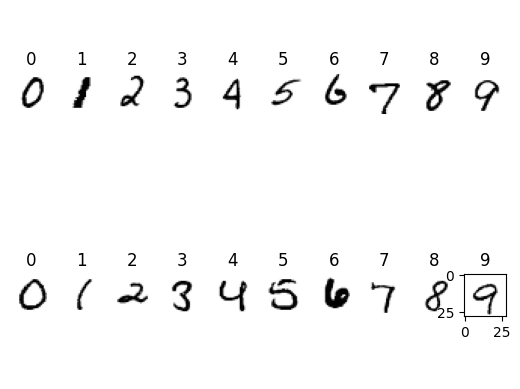

In [4]:
train_mnist=datasets.MNIST('data', train=True, download=True)
y_train_orig=train_mnist.targets.numpy()
for i in range(10):
  num_digits=2
  indices=np.random.choice(np.where(y_train_orig==i)[0],num_digits)
  for j in range(num_digits):
    plt.axis('off')
    plt.subplot(num_digits,10,10*j+i+1).set_title('{}'.format(i))
    img,_=train_mnist[indices[j]]
    plt.imshow(img, cmap='Greys')
plt.show()

In [5]:
batch_size = 128
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

train_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
train_dataset = datasets.MNIST(root='data', train=True,
                download=True, transform=train_transform)


test_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
test_dataset = datasets.MNIST(root='data', train=False,
            download=True, transform=test_transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
num_train = len(train_dataset)
split = int(np.floor(0.1 * num_train))
train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, **kwargs)

True
54000 6000


In [6]:
input_size=train_dataset[0][0].shape
num_classes=len(train_dataset.classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(np.prod(input_size), num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch):
  train_loss = 0.0
  total_train = 0
  correct_train = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % 10 == 0:
        display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)

      # accuracy
      _, predicted = torch.max(output.data, 1)
      train_loss += loss.item()
      total_train += target.nelement()  # number of pixel in the batch
      correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values

  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_acc = 100.*(correct_train / total_train)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
      epoch_loss,correct_train, total_train, epoch_acc))
  return epoch_loss,epoch_acc

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy=100. * correct / len(test_loader.dataset)

  print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))
  return test_loss,accuracy

In [7]:
!pip install torchtriton --extra-index-url "https://download.pytorch.org/whl/nightly/cu117"

!pip install triton

!pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.8 MB/s eta 0:00:00
Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 MB 6.8 MB/s eta 0:00:00


In [8]:
#!pip install --upgrade pip

In [9]:
!pip3 --version

pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
epochs = 20
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
model=torch.compile(model) #PyTorch
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-6-baf904c6b272> line 9 
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125] due to: 
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1209 10:33:02.536000 204 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/__init__

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.334030'

Train set: Average loss: 0.0030, Accuracy: 47918/54000 89%

Val set: Average loss: 0.3129, Accuracy: 5453/6000 (91%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.271801'

Train set: Average loss: 0.0024, Accuracy: 49239/54000 91%

Val set: Average loss: 0.3019, Accuracy: 5473/6000 (91%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.357437'

Train set: Average loss: 0.0022, Accuracy: 49689/54000 92%

Val set: Average loss: 0.2876, Accuracy: 5504/6000 (92%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.266264'

Train set: Average loss: 0.0022, Accuracy: 49823/54000 92%

Val set: Average loss: 0.2821, Accuracy: 5527/6000 (92%)



'Train Epoch: 5 [53760/54000 (100%)] Loss: 0.263995'

Train set: Average loss: 0.0021, Accuracy: 49884/54000 92%

Val set: Average loss: 0.2792, Accuracy: 5519/6000 (92%)



'Train Epoch: 6 [53760/54000 (100%)] Loss: 0.302777'

Train set: Average loss: 0.0021, Accuracy: 49941/54000 92%

Val set: Average loss: 0.2767, Accuracy: 5520/6000 (92%)



'Train Epoch: 7 [53760/54000 (100%)] Loss: 0.489825'

Train set: Average loss: 0.0021, Accuracy: 50056/54000 93%

Val set: Average loss: 0.2785, Accuracy: 5524/6000 (92%)



'Train Epoch: 8 [53760/54000 (100%)] Loss: 0.451957'

Train set: Average loss: 0.0020, Accuracy: 50080/54000 93%

Val set: Average loss: 0.2746, Accuracy: 5543/6000 (92%)



'Train Epoch: 9 [53760/54000 (100%)] Loss: 0.166120'

Train set: Average loss: 0.0020, Accuracy: 50134/54000 93%

Val set: Average loss: 0.2742, Accuracy: 5529/6000 (92%)



'Train Epoch: 10 [53760/54000 (100%)] Loss: 0.237295'

Train set: Average loss: 0.0020, Accuracy: 50157/54000 93%

Val set: Average loss: 0.2751, Accuracy: 5544/6000 (92%)



'Train Epoch: 11 [53760/54000 (100%)] Loss: 0.282044'

Train set: Average loss: 0.0020, Accuracy: 50183/54000 93%

Val set: Average loss: 0.2736, Accuracy: 5536/6000 (92%)



'Train Epoch: 12 [53760/54000 (100%)] Loss: 0.335681'

Train set: Average loss: 0.0020, Accuracy: 50211/54000 93%

Val set: Average loss: 0.2727, Accuracy: 5535/6000 (92%)



'Train Epoch: 13 [53760/54000 (100%)] Loss: 0.131529'

Train set: Average loss: 0.0020, Accuracy: 50217/54000 93%

Val set: Average loss: 0.2721, Accuracy: 5545/6000 (92%)



'Train Epoch: 14 [53760/54000 (100%)] Loss: 0.278806'

Train set: Average loss: 0.0020, Accuracy: 50231/54000 93%

Val set: Average loss: 0.2716, Accuracy: 5538/6000 (92%)



'Train Epoch: 15 [53760/54000 (100%)] Loss: 0.189312'

Train set: Average loss: 0.0020, Accuracy: 50246/54000 93%

Val set: Average loss: 0.2725, Accuracy: 5534/6000 (92%)



'Train Epoch: 16 [53760/54000 (100%)] Loss: 0.404216'

Train set: Average loss: 0.0020, Accuracy: 50254/54000 93%

Val set: Average loss: 0.2715, Accuracy: 5544/6000 (92%)



'Train Epoch: 17 [2560/54000 (5%)] Loss: 0.274704'

In [ ]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])